In [ ]:
! pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 4.0 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
import pywt
import re
import os
import wfdb
import statsmodels.api as sm
from scipy import signal
from scipy.signal import find_peaks
from scipy.fft import dct
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from scipy.signal import butter, filtfilt, ellip, decimate
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import skew





In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
/mydrive


In [ ]:
# !pip install wfdb

In [ ]:
record_path = "/content/drive/MyDrive/dataset/patient117/s0291lre"
signal, _ = wfdb.rdsamp(record_path)
signal1 = signal[0:15000, 0]

record_path0 = "/content/drive/MyDrive/patient122/s0312lre"
signal, _ = wfdb.rdsamp(record_path0)
signal2 = signal[0:15000, 0]

record_path = "/content/drive/MyDrive/dataset/patient173/s0305lre"
signal, _ = wfdb.rdsamp(record_path)
signal3 = signal[0:15000, 0]

record_path = "/content/drive/MyDrive/dataset/patient239/s0467_re"
signal, _ = wfdb.rdsamp(record_path)
signal4 = signal[0:15000, 0]

signalsArr = [signal1, signal2, signal3, signal4]


In [ ]:

def preprocess_signal(signal, fs, segment_length):
    if signal.ndim > 1:
        signal = signal.ravel()

    signal_dc_removed = signal - np.mean(signal)
    lowcut = 0.5
    highcut = 40
    rp = 0.1
    rs = 60

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = ellip(4, rp, rs, [low, high], btype='band')

    signal_filtered = filtfilt(b, a, signal_dc_removed)

    target_fs = 1000.0

    signal_normalized = (signal_filtered - np.mean(signal_filtered)) / np.std(signal_filtered)

    num_segments = len(signal_normalized) // segment_length
    segmented_signal = np.array_split(signal_normalized[:num_segments * segment_length], num_segments)

    overlap = 250

    num_segments = int(np.ceil((len(signal_normalized) - segment_length) / overlap)) + 1
    print(num_segments)

    segments = []
    for i in range(num_segments):
         start = i * overlap
         end = start + segment_length
         segment = signal_normalized[start:end]
         segments.append(segment)

    return segments


41


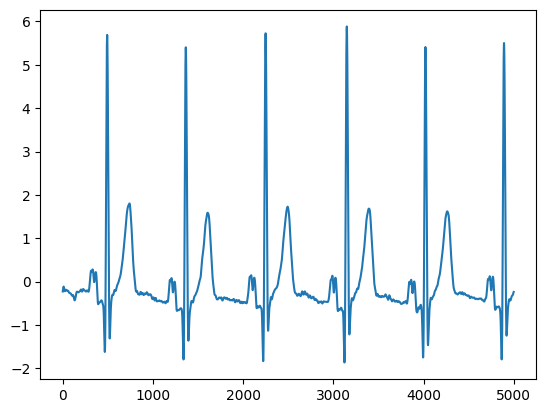

41


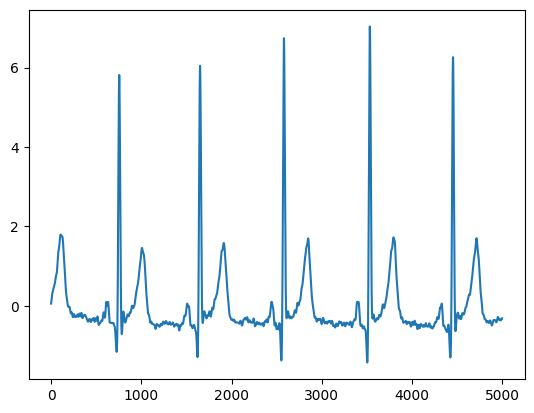

41


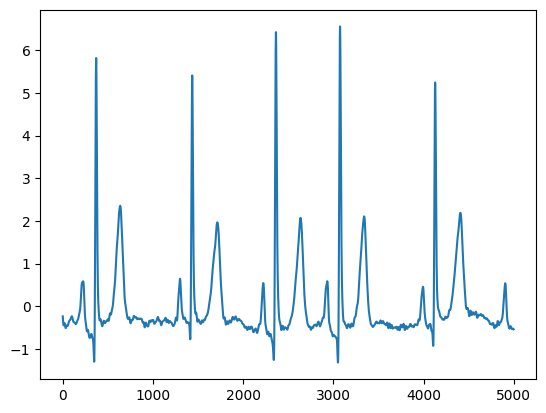

41


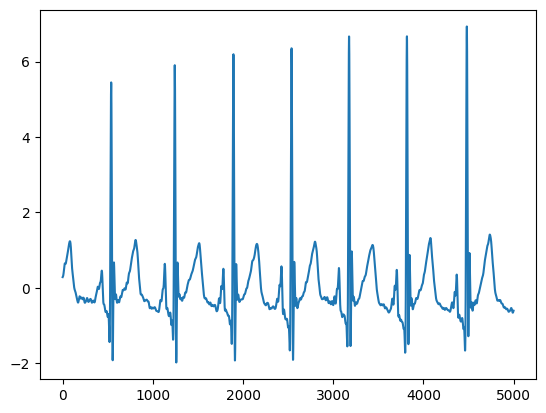

41


In [ ]:
segmented_signals = []
for i in range(0, 4):
  segmented_signals.append(preprocess_signal(signalsArr[i], 1000, 5000))
  plt.plot(segmented_signals[i][0])
  plt.show()
print(len(segmented_signals[0]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq


def extract_non_fiducial_features(ecg_signal):

    seg1 = np.array(ecg_signal)
    AC1 = sm.tsa.acf(seg1, nlags=900)
    s1 = AC1[0:500]
    DCT_1 = scipy.fftpack.dct(s1, type=2)


    return DCT_1


non_fiducial_features = []
labels=[]
X = []  # Features


for j in range(0,4):

  for i in range(0,41):

      non_fiducial_features = extract_non_fiducial_features(segmented_signals[j][i])


      X.append(non_fiducial_features)
      labels.append("person"+str(j+1))

X = np.array(X)
labels = np.array(labels)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Evaluate the classifier on the test set
accuracy = rf_classifier.score(X_test, y_test)
print("Accuracy:", accuracy)


Accuracy: 1.0


In [ ]:

 # Train an SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_classifier = LinearDiscriminantAnalysis()

# Fit the classifier to the training data
lda_classifier.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = lda_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Train an SVM model
svm_model = SVC(kernel='poly', degree=4, probability=True)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
f1score = f1_score(y_test, y_pred, average='macro')
print("F1 Score:", f1score)

Accuracy: 1.0
F1 Score: 1.0


ValueError: ignored

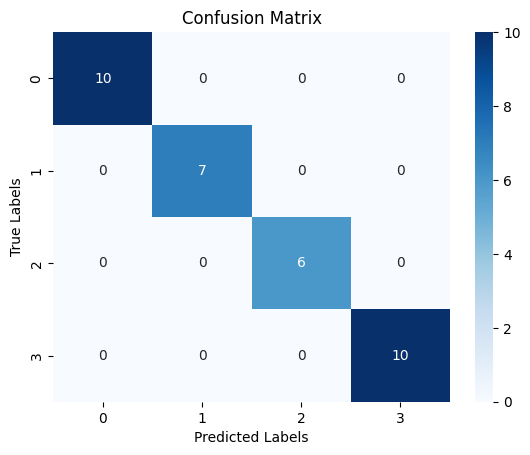

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()

# Plot the heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)

# Set labels, title, and axis ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

# Display the plot
plt.show()

In [ ]:
import pickle

with open('svm_model21.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq


def extract_non_fiducial_features(ecg_signal):
    sample_rate = 1000

    duration = len(ecg_signal) / sample_rate

    wavelet = 'db4'

    coeffs = pywt.wavedec(ecg_signal, wavelet, level=7)


    frequencies = pywt.scale2frequency(wavelet, np.arange(1, 7 + 1)) * sample_rate

    return frequencies


non_fiducial_features = []
labels=[]
X = []  # Features


for j in range(0,4):

  for i in range(0,11):

      non_fiducial_features = extract_non_fiducial_features(segmented_signals[j][i])


      X.append(non_fiducial_features)
      labels.append("person"+str(j+1))

X = np.array(X)
labels = np.array(labels)


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=42)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)
y_pred = lda_classifier.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6
